## Mapping Tech Companies in New York City

In [1]:
% matplotlib inline
from googleplaces import GooglePlaces, types, lang
import googlemaps
from datetime import datetime
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
import geopy

import re

In [2]:
with open("API_joyce_ignore", "r") as f:
    lines = f.readlines()
    google_places_api = lines[0].split(":")[1].strip()

API_KEY = google_places_api
google_places = GooglePlaces(API_KEY)
gmaps = googlemaps.Client(key = API_KEY)

### Finding most valuable tech companies in the US

Use BeautifulSoup to scrape a BusinessInsider article to get a list of the top 21 most valuable American tech companies. Webscraping functions taken from following website: https://realpython.com/python-web-scraping-practical-introduction/

In [3]:
# Webscraping function to  article to get list of the top most valuable tech companies in America.

from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup

def simple_get(url):
    """
    Attempts to get the content at `url` by making an HTTP GET request.
    If the content-type of response is some kind of HTML/XML, return the
    text content, otherwise return None.
    """
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content
            else:
                return None

    except RequestException as e:
        log_error('Error during requests to {0} : {1}'.format(url, str(e)))
        return None


def is_good_response(resp):
    """
    Returns True if the response seems to be HTML, False otherwise.
    """
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200 
            and content_type is not None 
            and content_type.find('html') > -1)


def log_error(e):
    """
    It is always a good idea to log errors. 
    This function just prints them, but you can
    make it do anything.
    """
    print(e)

If you view the page source of the Business Insider article, you can see that each company name is contained within an H2 tag with the class 'slide-title-text'. Use BeautifulSoup to find all the elements that meet these criteria, then clean up the list to get the names of the companies.

In [4]:
raw_html = simple_get('http://www.businessinsider.com/amazon-google-apple-most-valuable-tech-brands-america-2018-6')
soup = BeautifulSoup(raw_html, 'html.parser')
BI_companies = soup.find_all("h2", class_="slide-title-text")
BI_company_list = [company.text for company in BI_companies]
BI_company_list = [company.split(".")[1].strip() for company in BI_company_list]
print(BI_company_list)

['Qualcomm', 'Western Digital', 'eBay', 'Adobe', 'HPE', '3M', 'HP', 'booking', 'NETFLIX', 'Dell', 'Uber', 'Cisco', 'Intel', 'YouTube', 'Oracle', 'IBM', 'Microsoft', 'Facebook', 'Google', 'Apple', 'Amazon']


Now, define a function that iterates through the list of companies, and for each company query google_places with a text search for its office in New York. This query returns an array of 'Places'. Store these results in a dict, where the key is the name of the company and the value is the array of 'Places'.

Next, the verify_places function takes this dictionary and returns a DataFrame. It iterates through the dictionary, and for each company, go through the array of Places and attempt to verify if each 'Place' really is affiliated with the company. A simple way to do this is to check to see if the name of the company is in the 'Place' name, and also if the substring 'company name'.com is located in the 'Place' website. If both of these criteria are met, then this Place is likely to be truly associated with the company, and an entry for this 'Place' is inserted into the dataframe. Once the function is done iterating through the entire dictionary, the populated DataFrame is returned.

Finally, the make_geodf function turns the dataframe into a geo-dataframe, so that this can then be written to a geojson file.

In [11]:
def make_company_places_dict(company_list):
    company_place_dict = {}
    place_query = '{} office in New York City'
    for company in company_list:
        company_place_dict[company] = google_places.text_search(query=place_query.format(company))
    return company_place_dict

def verify_places(company_place_dict):
    company_df = pd.DataFrame(columns=['company_name', 'latitude', 'longitude'])
    
    for company in company_place_dict:
        for place in company_place_dict[company].places:
            score = 0
            place.get_details()
            if company.lower() in place.name.lower():
                score += 1
            if (company.lower() + ".com") in str(place.website).lower():
                score += 1
            if score == 2:
                row = pd.Series({'company_name':company, 'latitude':place.geo_location['lat'], 'longitude':place.geo_location['lng']})
                company_df = company_df.append(row, ignore_index=True)
                
    return company_df

def make_geodf(company_df):
    company_df['coordinates'] = list(zip(company_df['longitude'], company_df['latitude']))
    company_df['coordinates'] = company_df['coordinates'].apply(Point)
    company_geodf = gpd.GeoDataFrame(company_df).set_geometry('coordinates')
    
    company_geodf['latitude'] = pd.to_numeric(company_geodf['latitude'])
    company_geodf['longitude'] = pd.to_numeric(company_geodf['longitude'])
    company_geodf['company_name'] = company_geodf['company_name'].astype('str')
    
    return company_geodf

In [9]:
BI_dict = make_company_places_dict(BI_company_list)

In [12]:
BI_verified_places_df = verify_places(BI_dict)
BI_geodf = make_geodf(BI_verified_places_df)

In [14]:
BI_geodf.head()

,company_name,latitude,longitude,coordinates
0,Adobe,40.758051,-73.984844,POINT (-73.98484359999999 40.7580514)
1,Adobe,40.737094,-73.993177,POINT (-73.99317739999999 40.7370935)
2,NETFLIX,40.741194,-73.999811,POINT (-73.9998109 40.7411942)
3,Dell,40.708765,-74.011079,POINT (-74.01107890000002 40.7087649)
4,Dell,40.701496,-74.009170,POINT (-74.0091697 40.7014962)


In [15]:
BI_geodf.to_file("BI_companies.geojson", driver='GeoJSON')

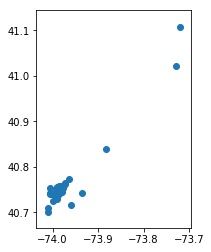

In [16]:
companies = gpd.read_file('BI_companies.geojson')
companies.plot()

## Top 100 NYC tech companies

Let's scrape a different article, this time an article published by BuiltInNYC listing the top 100 NYC-based tech companies.

In [18]:
raw_html = simple_get('https://www.builtinnyc.com/2017/11/07/nyc-top-100-tech-companies-2017')
soup = BeautifulSoup(raw_html, 'html.parser')

top_100 = soup.find_all("div", class_="company-info-wrapper")

def remove_html_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

top_100_company_list = []

for company in top_100:
    s = company.find_all("a", href=re.compile("https://www.builtinnyc.com/company/"))
    top_100_company_list.append(str(s))

top_100_company_list = list(map(remove_html_tags, top_100_company_list))
top_100_company_list = [company.split(",")[1].strip() for company in top_100_company_list]
top_100_company_list

['Bloomberg',
 'Oath',
 'CA Technologies',
 'Vice Media',
 'Blue Apron',
 'E*Trade',
 'BuzzFeed',
 'Yext',
 'FreshDirect',
 'Etsy',
 'AppNexus',
 'Refinery29',
 'Peloton',
 'Information Builders',
 'Flatiron Health',
 'Shutterstock',
 'Squarespace',
 'Infor',
 'Group Nine Media',
 'Oscar',
 'Gilt Groupe',
 'Intersection',
 'Namely',
 'The Business Insider',
 'XO Group Inc',
 'MediaMath',
 'Zocdoc',
 'Presidio',
 'Mediaocean',
 'Compass',
 'Casper',
 'Fareportal',
 'MongoDB',
 'Justworks',
 '1stdibs',
 'Integral Ad Science',
 '1010data',
 'Handy',
 'Warby Parker',
 'COMPLEX (dba Complex Media',
 'OnDeck',
 'BounceX',
 'Vimeo',
 'LearnVest',
 'Bonobos',
 'Datadog',
 'Sprinklr',
 'Betterment',
 'TMP Worldwide',
 '2U',
 'Rent the Runway',
 'ClassPass',
 'DigitalOcean',
 'Taboola',
 "Harry's",
 'Uncommon Goods',
 'Makerbot',
 'Moat',
 'Meetup',
 'JW Player',
 'Undertone',
 'Mashable',
 'Kargo',
 'Foursquare',
 'Greenhouse Software',
 'Braze (formerly Appboy)',
 'Zeta Interactive',
 'VTS',
 

In [19]:
top_100_dict = make_company_places_dict(top_100_company_list)

In [20]:
top_100_verified_places_df = verify_places(top_100_dict)
top_100_geodf = make_geodf(top_100_verified_places_df)

In [21]:
top_100_geodf.to_file("top_100_tech_nyc.geojson", driver='GeoJSON')

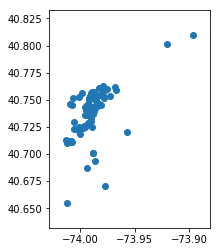

In [22]:
companies = gpd.read_file('top_100_tech_nyc.geojson')
companies.plot()

In [61]:
raw_html = simple_get('https://www.builtinnyc.com/2018/01/16/50-nyc-startups-watch-2018')
soup = BeautifulSoup(raw_html, 'html.parser')

new_50_2018 = soup.find_all("div", class_="company-info-wrapper")

def remove_html_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

company_list = []

for company in new_50_2018:
    test = company.find_all("a", href=re.compile("https://www.builtinnyc.com/company/"))
    company_list.append(str(test))

clean_company_list = list(map(remove_html_tags, company_list))
clean_company_list = [company.split(",")[1].strip() for company in clean_company_list]
clean_company_list

['Knotel',
 'Teachable',
 'Beeswax',
 'Call9',
 'mParticle',
 'Stash',
 'Roomi',
 'HyperScience',
 'Away',
 'Resy',
 'Zola',
 'quip',
 'Attune',
 'Aaptiv',
 'Anchor',
 'Bizly',
 'Blink Health',
 'Boxed',
 'Brooklinen',
 'Candid Co.',
 'CariClub',
 'Citizen App',
 'Civil',
 'Connatix',
 'ConsenSys',
 'CoverWallet',
 'Current',
 'Digital Currency Group',
 'Fatherly',
 'Feather',
 'Fevo',
 'Flip',
 'Hello Alfred',
 'Hubble Contacts',
 'Intersection',
 'Jackpocket',
 'Knock',
 'Knotch',
 'Laughable',
 'LeafLink',
 'Maven',
 'Meural',
 'Reality AI',
 'SelfMade',
 'Slice Labs',
 'The Helm',
 'The Karma Network',
 'Trilogy Education Services',
 'UnitedMasters',
 'Uplevel']

In [62]:
top_50 = make_company_places_dict(clean_company_list)

In [63]:
top_50_df = verify_places(top_50)
top_50_geodf = make_geodf(top_50_df)

In [64]:
top_50_geodf

,company_name,latitude,longitude,coordinates
0,Knotel,40.764362,-73.970652,POINT (-73.97065189999999 40.7617491)
1,Beeswax,40.740319,-73.989968,POINT (-73.9899683 40.7589301)
2,Call9,40.657592,-74.007128,POINT (-74.00712799999999 40.7520028)
3,mParticle,40.738623,-73.987135,POINT (-73.9871351 40.7369273)
4,HyperScience,40.741175,-73.993222,POINT (-73.99322169999999 40.7430974)
5,Zola,40.709154,-74.010113,POINT (-74.01011269999999 40.7410857)
6,quip,40.702882,-73.990433,POINT (-73.9904334 40.8014663)
7,Aaptiv,40.713272,-74.012925,POINT (-74.01292500000001 40.70058239999999)
8,Bizly,40.755105,-73.986209,POINT (-73.9862093 40.74189680000001)
9,Brooklinen,40.700813,-73.987545,POINT (-73.98754479999999 40.71196399999999)
